In [ ]:
pip install numpy pandas matplotlib scikit-learn scipy

In [ ]:
from sklearn.model_selection import train_test_split
import scipy.io
import pandas as pd
import numpy as np

thyroid_data = pd.read_csv('/content/thyroid.csv')

train_data, temp_data = train_test_split(thyroid_data, test_size=0.2, random_state=42)
valid_data, test_data = train_test_split(temp_data, test_size=0.2, random_state=42)

In [ ]:
print(thyroid_data.head())
print(thyroid_data.columns)
print(thyroid_data.index)

   feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  label
0   0.774194   0.001132   0.137571   0.275701   0.295775   0.236066    0.0
1   0.247312   0.000472   0.279886   0.329439   0.535211   0.173770    0.0
2   0.494624   0.003585   0.222960   0.233645   0.525822   0.124590    0.0
3   0.677419   0.001698   0.156546   0.175234   0.333333   0.136066    0.0
4   0.236559   0.000472   0.241935   0.320093   0.333333   0.247541    0.0
Index(['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5',
       'feature_6', 'label'],
      dtype='object')
RangeIndex(start=0, stop=3772, step=1)


In [ ]:
import numpy as np

def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

def manhattan_distance(x1, x2):
    return np.sum(np.abs(x1 - x2))

In [ ]:
def knn_detect_anomalies(data, k=5, threshold_percentile=95, distance_func=None, external_threshold=None):
    if distance_func is None:
        distance_func = lambda x1, x2: np.sqrt(np.sum((x1 - x2) ** 2))

    n_samples = len(data)
    distances = np.zeros((n_samples, n_samples))

    # compute distance between pointsi
    for i in range(n_samples):
        for j in range(i + 1, n_samples):
            dist = distance_func(data.iloc[i, :-1].values, data.iloc[j, :-1].values)
            distances[i, j] = dist
            distances[j, i] = dist  # distance is symetrical

    # looking for k nearest neighbours
    nearest_neighbors = np.argsort(distances, axis=1)[:, 1:k+1]

    # mean distance from k nearest neighbours
    anomaly_scores = np.mean(distances[np.arange(n_samples)[:, None], nearest_neighbors], axis=1)

    # if there's no threshold given, we determine treshold using percentile
    if external_threshold is None:
        threshold = np.percentile(anomaly_scores, threshold_percentile)
    else:
        threshold = external_threshold

    # classification as anomalies
    anomalies = anomaly_scores > threshold

    # data separation
    normal_data = data[~anomalies]
    anomaly_data = data[anomalies]

    return anomalies, normal_data, anomaly_data, anomaly_scores, threshold

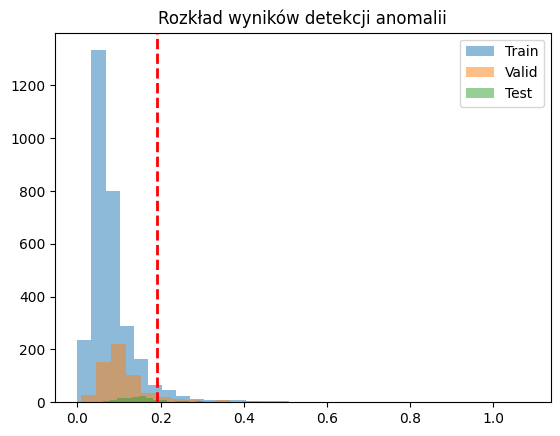

In [ ]:
anomalies_train, normal_train, anomaly_train, scores_train, threshold_train = knn_detect_anomalies(train_data, k=5, distance_func=manhattan_distance)
anomalies_valid, normal_valid, anomaly_valid, scores_valid, _ = knn_detect_anomalies(valid_data, k=5, distance_func=manhattan_distance, external_threshold=threshold_train)
anomalies_test, normal_test, anomaly_test, scores_test, _ = knn_detect_anomalies(test_data, k=5, distance_func=manhattan_distance, external_threshold=threshold_train)


import matplotlib.pyplot as plt

plt.hist(scores_train, bins=30, alpha=0.5, label='Train')
plt.hist(scores_valid, bins=30, alpha=0.5, label='Valid')
plt.hist(scores_test, bins=30, alpha=0.5, label='Test')
plt.axvline(x=threshold_train, color='r', linestyle='dashed', linewidth=2)
plt.legend()
plt.title('Rozkład wyników detekcji anomalii')
plt.show()

In [ ]:
def plot_data_with_anomalies(data, anomalies, normal, title='Visualization of Anomalies'):

    num_normals = len(normal)
    num_anomalies = np.sum(anomalies)

    normal_data = data[~anomalies]
    anomaly_data = data[anomalies]

    plt.figure(figsize=(10, 6))
    plt.scatter(normal_data.iloc[:, 0], normal_data.iloc[:, 1], color='blue', label=f'Normal ({num_normals})')
    plt.scatter(anomaly_data.iloc[:, 0], anomaly_data.iloc[:, 1], color='red', label=f'Anomaly ({num_anomalies})')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
from sklearn.decomposition import PCA

# redukcja wymiarowosci
pca = PCA(n_components=2)
data_pca1 = pca.fit_transform(train_data.iloc[:, :-1])  # last column contains labels

# conversion back to df
train_data_pca_df = pd.DataFrame(data_pca1, columns=['PCA1', 'PCA2'])

data_pca2 = pca.fit_transform(valid_data.iloc[:, :-1])

valid_data_pca_df = pd.DataFrame(data_pca2, columns=['PCA1', 'PCA2'])

data_pca3 = pca.fit_transform(test_data.iloc[:, :-1])

test_data_pca_df = pd.DataFrame(data_pca3, columns=['PCA1', 'PCA2'])

In [ ]:
plot_data_with_anomalies(train_data_pca_df, anomalies_train, normal_train, title='Train Data Anomalies')
plot_data_with_anomalies(valid_data_pca_df, anomalies_valid, normal_valid, title='Validation Data Anomalies')
plot_data_with_anomalies(test_data_pca_df, anomalies_test, normal_test, title='Test Data Anomalies')

print('TRAIN: normal:', len(normal_train), ", anomalies:", np.sum(anomalies_train))
print('VALID: normal:', len(normal_valid), ", anomalies:", np.sum(anomalies_valid))
print('TEST: normal:', len(normal_test), ", anomalies:", np.sum(anomalies_test))

IndexError: single positional indexer is out-of-bounds

<Figure size 1000x600 with 0 Axes>